Extension of Example 1 to two uncertainty sources
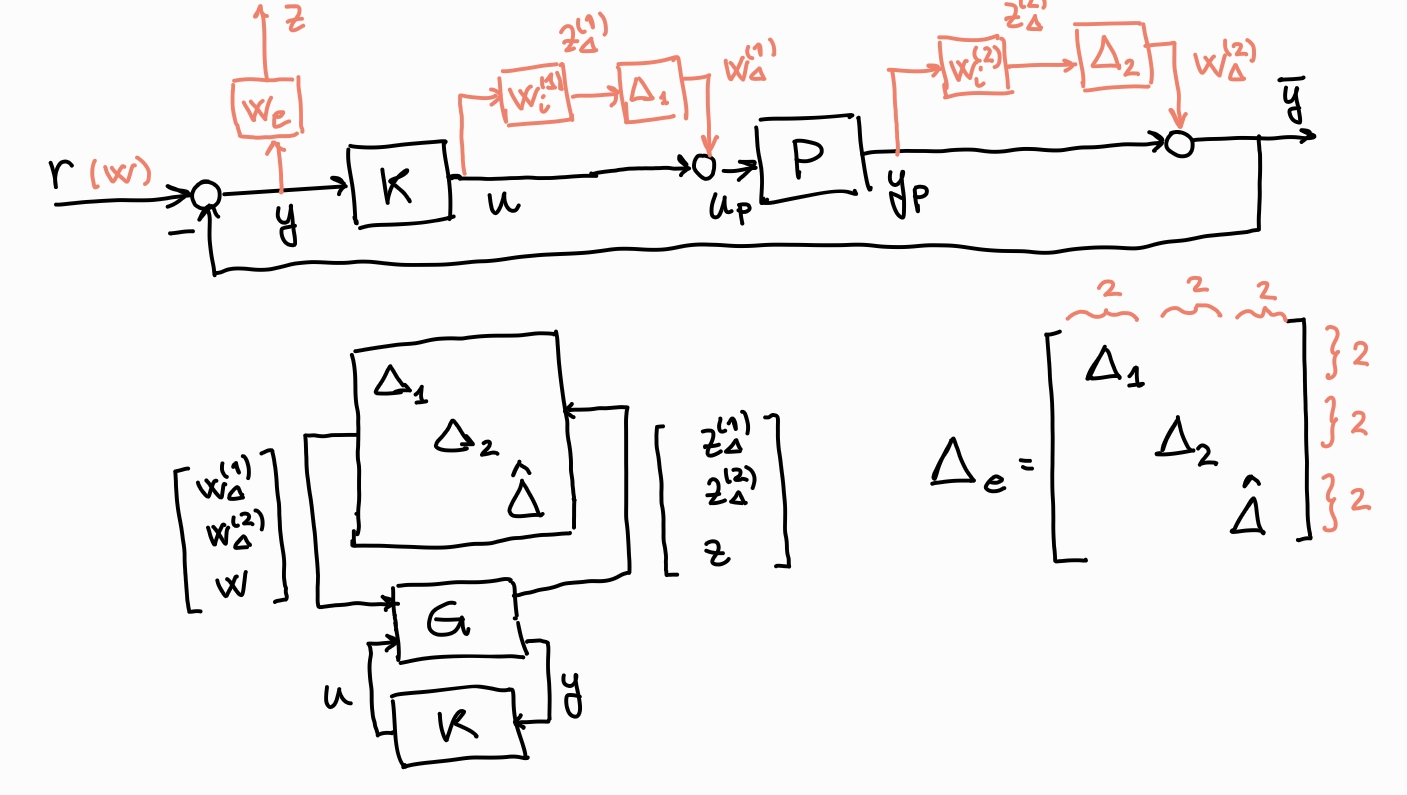

Plant uncertainty model is $P_p=(I+\Delta W_{i,2})P(I+\Delta W_{i,1})$, with $W_{i,1}=w_{i,1} I$, $W_{i,2}=w_{i,2} I$.

In [1]:
import matplotlib.pyplot as plt
from itertools import product
import slycot as sly
import numpy as np
import control as ct
import rpc_diism.robust as rb
s= ct.tf('s')

In [2]:
# Plant P
den = [75, 1]
P = ct.tf([[[87.8], [-86.4]],
              [[108.2], [-109.6]]],
             [[den, den],
              [den, den]])
display("Plant transfer function", P)

'Plant transfer function'

TransferFunction(
[[array([87.8]), array([-86.4])],
 [array([108.2]), array([-109.6])]],
[[array([75,  1]), array([75,  1])],
 [array([75,  1]), array([75,  1])]],
outputs=2, inputs=2)

Define performance weight and uncertainty weight 

In [3]:
# Uncertainty block 1 weight Wi (uncertain input gain + neglected delay, see example 1)
w_i1 = ct.tf([1,0.2],[0.5,1])
Wi1 = w_i1.append(w_i1) 
display("Uncertainty weight", Wi1)

# Uncertainty block 2 weight Wi2 (uncertain output gain, nominal = 1)
Kmin = 0.9
Kmax = 1.1
Km = 0.5*(Kmin+Kmax)
alpha = (Kmax-Kmin)/2/Km
wi2_1 = ct.ss([],[],[],alpha)
Wi2 = wi2_1.append(wi2_1) 

# Performance weight We (weight on S)
w_e = 0.8*ct.tf([0.5,0.05],[1,1e-6])
We = w_e.append(w_e)
display("Performance weight", We)

'Uncertainty weight'

TransferFunction(
[[array([1. , 0.2]), array([0.])],
 [array([0.]), array([1. , 0.2])]],
[[array([0.5, 1. ]), array([1.])],
 [array([1.]), array([0.5, 1. ])]],
outputs=2, inputs=2)

'Performance weight'

TransferFunction(
[[array([0.4 , 0.04]), array([0.])],
 [array([0.]), array([0.4 , 0.04])]],
[[array([1.e+00, 1.e-06]), array([1.])],
 [array([1.]), array([1.e+00, 1.e-06])]],
outputs=2, inputs=2)

Construct the LFT

In [4]:
Wi1.input_labels = ['u[0]', 'u[1]']
Wi1.output_labels = ['zdelta1[0]', 'zdelta1[1]']
Wi2.input_labels = ['yp[0]', 'yp[1]']
Wi2.output_labels = ['zdelta2[0]', 'zdelta2[1]']
We.input_labels = ['y[0]', 'y[1]']
We.output_labels = ['z[0]', 'z[1]']
P.input_labels = ['up[0]','up[1]']
P.output_labels = ['yp[0]','yp[1]']

# Summing junctions from uncertain blocks
sumdelta1 = ct.summing_junction(inputs=['u','wdelta1'], output='up', dimension=2)
sumdelta2 = ct.summing_junction(inputs=['yp','wdelta2'], output='ybar', dimension=2)

# Feedback: y = r-ybar
fbk = ct.summing_junction(inputs=['w','-ybar'], output='y', dimension=2)

# Generate the G transfer function of the LFT
G = ct.minreal(ct.interconnect([P, Wi1, Wi2, We, sumdelta1, sumdelta2, fbk],
                    inputs=['wdelta1[0]','wdelta1[1]','wdelta2[0]','wdelta2[1]','w[0]','w[1]','u[0]','u[1]'],
                    outputs=['zdelta1[0]','zdelta1[1]','zdelta2[0]','zdelta2[1]','z[0]','z[1]','y[0]','y[1]']), 
                    verbose=False)

Do $\mu$-synthesis

In [5]:
# Controller I/O sizes
f = 2

# Extended uncertainty structure: two 2x2 uncertainty blocks and a 2x2 performance block
nblock = np.array([2,2,2])
# This has to be == 2 (complex uncertainty) for each block (other values are not implemented)
itype = np.array([2,2,2])

# Frequency range for mu computations
omega = np.logspace(-3, 3, 61)

# Do mu-synthesis via D-K iteration
# Note that we enforce reduction on the closed loop of each iteration. If we don't, numerical problems arise
# for this problem instance
K, best_nubar, init_mubar, best_mubar, gamma = rb.musyn(G, f, nblock, itype, omega)

display("Best upper bound (nubar) to mu norm of Tzw_delta: ", best_nubar)

Infinity norm of Tzw_delta with initial Hinfinity controller:  1.2321276372517787
Iteration # 1
Best upper bound to mu norm of Tzw_delta:  1.1341317401239972
Iteration # 2
Best upper bound to mu norm of Tzw_delta:  1.0200127955573335
Iteration # 3
No better upper bound to mu norm of Tzw_delta found: trying D order  5 qutol  1.0
Iteration # 4
No better upper bound to mu norm of Tzw_delta found: trying D order  6 qutol  1.0
Iteration # 5
No better upper bound to mu norm of Tzw_delta found: trying D order  7 qutol  1.0
Iteration # 6
No better upper bound to mu norm of Tzw_delta found: trying D order  8 qutol  1.0
Iteration # 7
No better upper bound to mu norm of Tzw_delta found: trying D order  4 qutol  2.0
Iteration # 8
No better upper bound to mu norm of Tzw_delta found: trying D order  5 qutol  2.0
Iteration # 9
No better upper bound to mu norm of Tzw_delta found: trying D order  6 qutol  2.0
Iteration # 10
No better upper bound to mu norm of Tzw_delta found: trying D order  7 qutol  2

'Best upper bound (nubar) to mu norm of Tzw_delta: '

1.0200127955573335

Plot initial and final $\mu$ upper bound $\bar\mu$ with frequency

Text(0.5, 1.0, 'Initial and final $\\bar\\mu$')

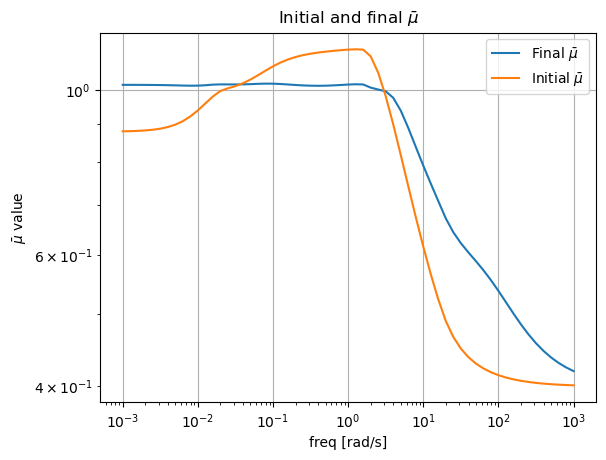

In [6]:
plt.loglog(omega, best_mubar, label=r'Final $\bar \mu$')
plt.loglog(omega, init_mubar, label=r'Initial $\bar \mu$')
plt.ylabel(r'$\bar\mu$ value')
plt.xlabel('freq [rad/s]')
plt.legend()
plt.grid()
plt.title(r'Initial and final $\bar\mu$')

Verify performance on the nominal system. It must hold that $\|W_e S\|_\infty \leq \bar\nu$. 

Text(0.5, 1.0, 'Singular values of S vs. nubar*inv(We) for the nominal system')

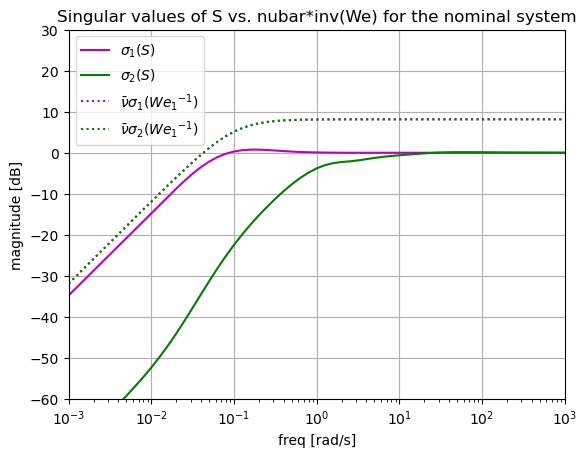

In [7]:
# Compute closed loop sensitivity for the nominal system
I = ct.ss([], [], [], np.eye(2)) # Identity system  
Delta1 = 0 * I
Delta2 = 0 * I
Delta1.input_labels = ['zdelta1[0]','zdelta1[1]']
Delta1.output_labels = ['wdelta1[0]','wdelta1[1]']   
Delta2.input_labels = ['zdelta2[0]','zdelta2[1]']
Delta2.output_labels = ['wdelta2[0]','wdelta2[1]'] 
K.input_labels = ['y[0]','y[1]']
K.output_labels = ['u[0]','u[1]'] 

S = ct.minreal(ct.interconnect([P, Delta1, Delta2, K, Wi1, Wi2, We, sumdelta1, sumdelta2, fbk],
                    inputs=['w[0]','w[1]'],
                    outputs=['y[0]','y[1]'], check_unused=False), verbose=False)

# Compute singular values of S over frequency
Ssv = rb.sigma(S, omega)

# We plot the singular values of gamma*invss(We) along with S
# for gamma = best_mubar
Weinv = rb.invss(ct.ss(We))
Weinvsv = rb.sigma(Weinv, omega) * best_nubar

plt.semilogx(omega, 20*np.log10(Ssv[:, 0]), 'm', label=r'$\sigma_1(S)$')
plt.semilogx(omega, 20*np.log10(Ssv[:, 1]), 'g', label=r'$\sigma_2(S)$')
plt.semilogx(omega, 20*np.log10(Weinvsv[:, 0]), 'm:', label=r'$\bar\nu \sigma_1({We_1}^{-1})$')
plt.semilogx(omega, 20*np.log10(Weinvsv[:, 1]), 'g:', label=r'$\bar\nu \sigma_2({We_1}^{-1})$')
plt.ylim([-60, 30])
plt.ylabel('magnitude [dB]')
plt.xlim([1e-3, 1e3])
plt.xlabel('freq [rad/s]')
plt.legend()
plt.grid()
plt.title('Singular values of S vs. nubar*inv(We) for the nominal system')

To demonstrate the importance of considering the structure in computing the robust performance controller, we solve the robust stability problem that is equivalent to robust performance using the small-gain theorem instead of $\mu$ (hence neglecting the structure ${\mathbf \Delta}_e$). This is done by computing an $H_\infty$ controller that ensures only the small gain condition. We compare the obtained controller with the $\mu$-synthesis controller on the nominal closed-loop. Note that the $H_\infty$ problem is solved to the global optimum, while the solution of $\mu-$synthesis is only suboptimal. In spite of this, $\mu$-synthesis performs better.

In [8]:
# Design the small-gain controller
KH, cl0, gamma, rcond = ct.hinfsyn(G, f, f)
KH.input_labels = ['y[0]','y[1]']
KH.output_labels = ['u[0]','u[1]'] 

# Compare the level of performance obtained by small gain and mu controllers
display("Gamma of the small gain controller: ", gamma)
display("Best nubar of the mu controller: ", best_nubar)

'Gamma of the small gain controller: '

1.2321276357622115

'Best nubar of the mu controller: '

1.0200127955573335

This clearly shows that the $\mu-$synthesis controller achieves a level of performance $\|W_e S\|_\infty \leq\bar\nu$ in an uncertainty set $\|\Delta\|_\infty < 1/\bar\nu$ which are respectively better and larger than the level of performance $\|W_e S\|_\infty \leq\gamma$ and uncertainty set $\|\Delta\|_\infty < 1/\gamma$ ensured by the small gain condition!

Now we verify the performance under a perturbation satisfying the bound $\|\Delta\|_\infty = 1/ \bar\nu$, that is, on the boundary of the uncertainty set where the level of robust performance $\|W_e S\|_\infty \leq\bar\nu$ is guaranteed by the $\mu-$synthesis controller. We also compute the level of performance under the same perturbation for the controller computed using small gain, ignoring the structure of ${\mathbf \Delta}_e$.

Text(0.5, 1.0, 'Singular values of S vs. nubar*inv(We) for perturbed system')

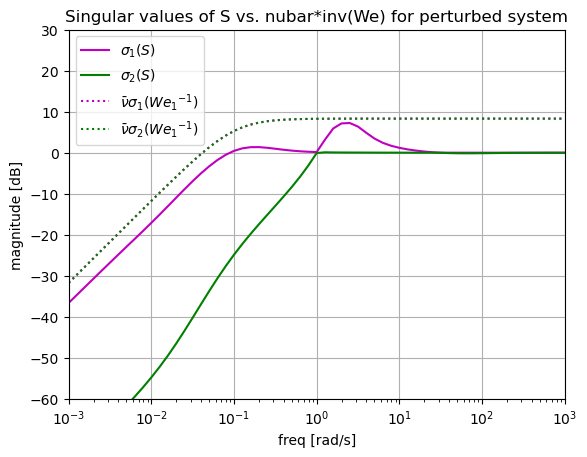

In [9]:
# Generate an admissible perturbed plant
Dp = 1/best_nubar * ct.tf([-1,0.2],[0.5,1])
Dp = Dp.append(Dp)

Pp = (I+0.1/best_nubar*I) * P * (I+Dp)
Pp.input_labels = ['up[0]','up[1]']
Pp.output_labels = ['yp[0]','yp[1]']

# Sensitivity of perturbed system
Sp = ct.minreal(ct.interconnect([Pp, Delta1, Delta2, K, Wi1, Wi2, We, sumdelta1, sumdelta2, fbk],
                    inputs=['w[0]','w[1]'],
                    outputs=['y[0]','y[1]'], check_unused=False), verbose=False)

# Compute singular values of S over frequency
Spsv = rb.sigma(Sp, omega)

# Plot the singular values of gamma*invss(We) along with S
# for gamma = best_mubar
plt.semilogx(omega, 20*np.log10(Spsv[:, 0]), 'm', label=r'$\sigma_1(S)$')
plt.semilogx(omega, 20*np.log10(Spsv[:, 1]), 'g', label=r'$\sigma_2(S)$')
plt.semilogx(omega, 20*np.log10(best_nubar*Weinvsv[:, 0]), 'm:', label=r'$\bar\nu \sigma_1({We_1}^{-1})$')
plt.semilogx(omega, 20*np.log10(best_nubar*Weinvsv[:, 1]), 'g:', label=r'$\bar\nu  \sigma_2({We_1}^{-1})$')
plt.ylim([-60, 30])
plt.ylabel('magnitude [dB]')
plt.xlim([1e-3, 1e3])
plt.xlabel('freq [rad/s]')
plt.legend()
plt.grid()
plt.title('Singular values of S vs. nubar*inv(We) for perturbed system')

Now let's see how the small gain controller behaves on the perturbed system.

Text(0.5, 1.0, 'Singular values of S vs. nubar*inv(We) for perturbed system')

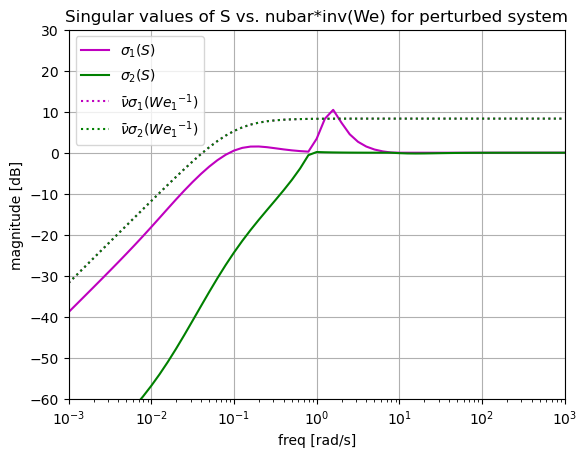

In [10]:
# Sensitivity of perturbed system with small gain controller
Sp = ct.minreal(ct.interconnect([Pp, Delta1, Delta2, KH, Wi1, Wi2, We, sumdelta1, sumdelta2, fbk],
                    inputs=['w[0]','w[1]'],
                    outputs=['y[0]','y[1]'], check_unused=False), verbose=False)

# Compute singular values of S over frequency
Spsv = rb.sigma(Sp, omega)

# Plot the singular values of gamma*invss(We) along with S
# for gamma = best_mubar
plt.semilogx(omega, 20*np.log10(Spsv[:, 0]), 'm', label=r'$\sigma_1(S)$')
plt.semilogx(omega, 20*np.log10(Spsv[:, 1]), 'g', label=r'$\sigma_2(S)$')
plt.semilogx(omega, 20*np.log10(best_nubar*Weinvsv[:, 0]), 'm:', label=r'$\bar\nu \sigma_1({We_1}^{-1})$')
plt.semilogx(omega, 20*np.log10(best_nubar*Weinvsv[:, 1]), 'g:', label=r'$\bar\nu  \sigma_2({We_1}^{-1})$')
plt.ylim([-60, 30])
plt.ylabel('magnitude [dB]')
plt.xlim([1e-3, 1e3])
plt.xlabel('freq [rad/s]')
plt.legend()
plt.grid()
plt.title('Singular values of S vs. nubar*inv(We) for perturbed system')

The controller computed neglecting the structure is unable to guarantee the level of performance $\|W_e S\|_\infty \leq\bar\nu$ that the $\mu$-synthesis one guarantees robustly, despite the fact that the $\mu-$synthesis solution is only suboptimal. This tells us that considering the structure leads to less conservative results despite suboptimality!